In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import jax.numpy as jnp
from jax import grad, jacfwd
from scipy.optimize import minimize

In [2]:
def car2pol(x, y):
    """ Converts from cartesian (x,y) to polar (r,θ) coordinates. """
    r = jnp.sqrt(x**2 + y**2)
    theta = jnp.arctan2(y, x)
    return r, theta


def wrap2pi(theta):
    """ Wraps an angle (in radians) to the range [-π, π]. """
    return theta - 2*np.pi*np.floor((theta+np.pi)/(2*np.pi))


def true_wind(lon, lat):
    """ true wind velocity (vector field) """
    u = 1.
    v = 0.
    return u, v

In [3]:
def dynamics(x, u, p):
    ''' Nonlinear dynamics of the sailboat model. '''
    lon, lat, theta, v, omega = x
    d_r, d_s = u
    
    # true wind
    u_tw, v_tw = true_wind(lon, lat)
    a_tw, psi_tw = car2pol(u_tw, v_tw)
    
    # apparent wind
    u_aw = a_tw * jnp.cos(psi_tw - theta) - v
    v_aw = a_tw * jnp.sin(psi_tw - theta)
    a_aw, psi_aw = car2pol(u_aw, v_aw)
    
    # forces
    g_s = p[3] * a_aw * jnp.sin(d_s - psi_aw)
    g_r = p[4] * v**2 * jnp.sin(d_r)

    # dynamics
    x_dot = jnp.array([v*jnp.cos(theta) + p[0]*a_tw*jnp.cos(psi_tw),
                      v*jnp.sin(theta) + p[0]*a_tw*jnp.sin(psi_tw),
                      omega,
                      (g_s*jnp.sin(d_s) - g_r*p[10]*jnp.sin(d_r) - p[1]*v**2)/(p[8]),
                      (g_s*(p[5] - p[6]*jnp.cos(d_s)) - g_r*p[7]*jnp.cos(d_r) - p[2]*omega*v)/(p[9])])

    return x_dot

In [4]:
def rk4(x, u, p, dt):
    """ Runge-Kutta (4th order) explicit integration. """
    k1 = dt*dynamics(x, u, p)
    k2 = dt*dynamics(x + k1/2, u, p)
    k3 = dt*dynamics(x + k2/2, u, p)
    k4 = dt*dynamics(x + k3, u, p)

    x_next = np.array(x + (k1 + 2*k2 + 2*k3 + k4)/6)
    # x_next[3] = wrap2pi(x_next[3])
    
    return x_next


def hermite_simpson(x1, x2, u, p, dt):
    """ Hermite-Simpson implicit integration. """
    x1_dot = dynamics(x1, u, p)
    x2_dot = dynamics(x2, u, p)

    x_mid = (x1 + x2)/2 + dt*(x1_dot - x2_dot)/8

    return x1 + dt*(x1_dot + 4*dynamics(x_mid, u, p) + x2_dot)/6 - x2

In [5]:
p = jnp.array([0.03, 40, 6000, 200, 1500, 0.5, 0.5, 2, 300, 400, 0.2])
x0 = jnp.array([0.0, 0.0, np.pi/2, 0.0, 0.0])
xg = jnp.array([-5.0, 15.0, 0.0, 0.0, 0.0])
u = jnp.array([0, jnp.pi/16])
dt = 0.1
tf = 25

N = int(tf/dt)
nx = 5
nu = 2
nz = (N-1) * nu + N * nx
idx_x = [jnp.array(range(i*(nx+nu), i*(nx+nu)+nx)) for i in range(N)]
idx_u = [jnp.array(range(i*(nx+nu)+nx, i*(nx+nu)+nx+nu)) for i in range(N-1)]

Q = jnp.diag(jnp.array([1., 1., 0., 0., 0.]))
R = 0.1*jnp.eye(nu)
Qf = 10*Q

In [6]:
z0 = 0.001*np.random.randn(nz)
z0[idx_x[0]] = x0

for i in range(N-1):
    z0[idx_u[i]] = u
    z0[idx_x[i+1]] = rk4(z0[idx_x[i]], z0[idx_u[i]], p, dt)

In [7]:
def cost(z):
    J = 0 
    for i in range(N-1):
        xi = z[idx_x[i]]
        ui = z[idx_u[i]]
        J += (xi - xg).T @ Q @ (xi - xg)
        J += ui.T @ R @ ui

    xf = z[idx_x[N-1]]
    J += (xf - xg).T @ Qf @ (xf - xg)
    
    return J

In [8]:
def dyncon(z):
    c = []
    for i in range(N-1):
        xi = z[idx_x[i]]
        ui = z[idx_u[i]]
        xip1 = z[idx_x[i+1]]
        c.extend(hermite_simpson(xi, xip1, ui, p, dt))
    return jnp.array(c)

dynamics_constraint = {
    'type': 'eq',
    'fun': dyncon,
    'jac': jacfwd(dyncon)
}

# primal bounds
z_bounds = np.array([(None, None) for i in range(nz)])
z_bounds[idx_x[0]] = [(x0[i], x0[i]) for i in range(nx)]
for k in range(N-1):
    z_bounds[idx_u[k]] = [(-np.pi/3, np.pi/3), (-np.pi/3, np.pi/3)]

In [10]:
def callback(z):
    print(f'cost: {cost(z)}')
    print(f'dynamics constraint: {np.sum(np.abs(dyncon(z)))}')

callback(z0)
res = minimize(cost, z0, method='SLSQP', jac=jacfwd(cost), bounds=z_bounds, constraints=[dynamics_constraint], callback=callback, options={'maxiter': 10})
print(res)

z = res.x
X = z[idx_x].reshape(N, nx)
U = z[idx_u].reshape(N-1, nu)

cost: 29613.025390625
dynamics constraint: 1.419044565409422e-06
cost: 20005.443359375
dynamics constraint: 195.26158142089844


/opt/anaconda3/envs/SailboatModel2D/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


cost: 19021.53125
dynamics constraint: 179.12091064453125
cost: 20360.474609375
dynamics constraint: 218.03604125976562
cost: 19657.61328125
dynamics constraint: 210.2918243408203
cost: 18041.248046875
dynamics constraint: 114.4267349243164
cost: 20838.509765625
dynamics constraint: 106.46405792236328
cost: 20780.080078125
dynamics constraint: 98.91920471191406
cost: 18595.73828125
dynamics constraint: 74.90568542480469
cost: 20107.67578125
dynamics constraint: 86.88581848144531
cost: 17167.654296875
dynamics constraint: 7.328435897827148
 message: Iteration limit reached
 success: False
  status: 9
     fun: 17167.654296875
       x: [ 0.000e+00  0.000e+00 ...  6.624e-04  2.893e-01]
     nit: 10
     jac: [ 1.000e+01 -3.000e+01 ...  0.000e+00  0.000e+00]
    nfev: 22
    njev: 10


In [30]:
def plot_boat(ax, x, u, p):
    lon, lat, theta, v, omega = x
    d_r, d_s = u
    k1 = 0.4 # boat width scale factor
    k3 = 0.3 # rudder scale factor

    points = np.array([[lon + (p[5]+p[6])*np.cos(theta), lat + (p[5]+p[6])*np.sin(theta)],
                        [lon + k1*p[6]*np.sin(theta) + p[5]*np.cos(theta), lat - k1*p[6]*np.cos(theta) + p[5]*np.sin(theta)],
                        [lon + k1*p[6]*np.sin(theta) - p[6]*np.cos(theta), lat - k1*p[6]*np.cos(theta) - p[6]*np.sin(theta)],
                        [lon - k1*p[6]*np.sin(theta) - p[6]*np.cos(theta), lat + k1*p[6]*np.cos(theta) - p[6]*np.sin(theta)],
                        [lon - k1*p[6]*np.sin(theta) + p[5]*np.cos(theta), lat + k1*p[6]*np.cos(theta) + p[5]*np.sin(theta)]])

    ax.fill(points[:,0], points[:,1], color='k', alpha=0.2) # boat
    ax.arrow(lon-p[6]*np.cos(theta), lat-p[6]*np.sin(theta), -k3*p[6]*np.cos(theta+d_r), -k3*p[6]*np.sin(theta+d_r)) # rudder
    ax.arrow(lon+p[5]*np.cos(theta), lat+p[5]*np.sin(theta), -2*p[5]*np.cos(theta+d_s), -2*p[5]*np.sin(theta+d_s)) # sail

def plot_wind(ax):
    xs,ys = np.meshgrid(np.linspace(-20,20,20), np.linspace(-20,20,20))
    xs,ys = xs.flatten(),ys.flatten()
    us,vs = np.array([true_wind(x,y) for x,y in zip(xs, ys)]).T

    ax.quiver(xs, ys, us, vs, linewidth=0.05, color='#A23BEC') 


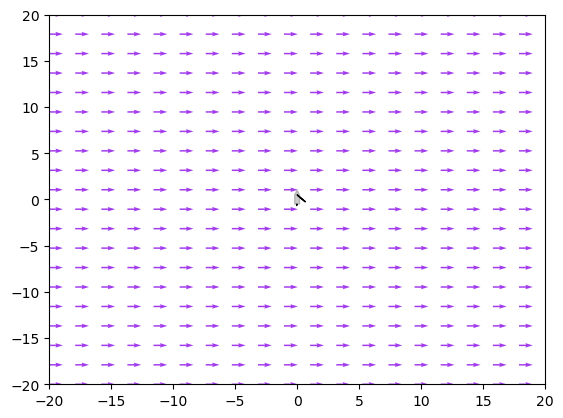

In [31]:
fig, ax = plt.subplots()

def func(k):
    ax.cla()
    plot_wind(ax)
    plot_boat(ax, X[k], U[k], p)
    ax.set_ylim([-20, 20])
    ax.set_xlim([-20, 20])

ani = FuncAnimation(fig, func, frames=range(N-1));
ani.save('test.mp4', writer='ffmpeg', fps=10)